# LSTM Text Generation with Keras

In [2]:
# scientific number crunching
import numpy as np
import pandas as pd
from scipy.io import loadmat
from keras.utils import to_categorical

# machine learning
import keras
from keras import models
from keras.layers import LSTM, Dense, Embedding, Dropout, Input, Flatten
from keras import optimizers
from keras import metrics

# drawing nice pictures
import matplotlib.pyplot as plt

# stopwatch
import time

Using TensorFlow backend.


## Load Data

In [0]:
# Data Params #

vocab_size = 2500 # words that are not in the most common 1000 are represented as 'oov'
test_split = 0
padding_char = -1
start_char = -1   # char that marks beginning of sequence 
oov_char = 0      # char that marks an oov token
index_from = 1    # first real word
seed = 1991

In [4]:
# Load it
from keras.datasets import reuters
(train, _), (_, _) = reuters.load_data(path="reuters.npz",
                                       num_words=vocab_size)
#                                          test_split=test_split,
#                                          seed=seed,
#                                          start_char=start_char,
#                                          oov_char=oov_char,
#                                          index_from=index_from)

word_index = reuters.get_word_index(path="reuters_word_index.json")
v = len(word_index)

train.shape[0]

557056/550378 [==============================] - 0s 0us/step


8982

In [5]:
word_index
index_word = {i: w for w, i in word_index.items()}
index_word[1], index_word[2], index_word[3], index_word[4], index_word[5]

('the', 'of', 'to', 'in', 'said')

In [100]:
# First let's look at some training examples.

def one_hot_sequence_to_text(oh):
  return 'none'

def vec_to_text(vec):
  words = []
  for i in vec:
    
    if type(i) != int:
      i = int(i)
      
    if i == 0:
      words.append('END')
    elif i == 2:
      words.append('--')
    elif i == 1:
      words.append('START')
    else:
      words.append(index_word[i-3])
  return ' '.join(words)

print(train[0])
print(vec_to_text(train[0]))
print(vec_to_text(train[1]))
print(vec_to_text(train[2]))

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
START -- -- said as a result of its december acquisition of -- co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and -- operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
START -- de -- sa lt -- -- and lt -- overseas corp of chicago have each taken 50 pct -- in -- company sa -- factors -- de -- said in a statement it gave no financial details of the transaction sa -- -- turnover in 1986 was 17 5 billion belgian francs reuter 

In [7]:
train[0].count(2)

4

In [8]:
# Turn it into sequence/next pairs
seq_len = 8

X  = []
y = []

for line in train:
  if line.count(2)/len(line) <= 0.1: #if there are fewer than 10% unknowns 
    i=0
    while (i+seq_len < len(line)):
      X.append(line[i:i+seq_len])
      y.append(line[i+seq_len])
      i += 1

print(X[:3])
print(y[:3])

[[1, 2, 2, 8, 43, 10, 447, 5], [2, 2, 8, 43, 10, 447, 5, 25], [2, 8, 43, 10, 447, 5, 25, 207]]
[25, 207, 270]


In [9]:
len(X)

454888

In [12]:
# Split it into train/val/test
train_size = 75000
val_size = 20000

X_train = np.array(X[:train_size])
y_train = np.array(y[:train_size])
X_val = np.array(X[train_size:(train_size+val_size)])
y_val = np.array(y[train_size:(train_size+val_size)])
X_test = np.array(X[train_size+val_size:])
y_test = np.array(y[train_size+val_size:])

print(X_train.shape, y_train.shape)

(75000, 8) (75000,)


In [0]:
# response variable should be one-hot
y_train = to_categorical(y_train, num_classes=vocab_size)
y_val = to_categorical(y_val, num_classes=vocab_size)
y_test = to_categorical(y_test, num_classes=vocab_size)

## Model

In [0]:
model = models.Sequential()

#         Embedding(vocab size, embedding size, input length (necessary for flatten and dense))
model.add(Embedding(vocab_size, 64, input_length=seq_len))
model.add(LSTM(32, return_sequences=True)) # returns a sequence of vectors of dimension 32
model.add(Dropout(rate=0.25))
model.add(LSTM(32, return_sequences=True)) # returns a sequence of vectors of dimension 32
model.add(Dropout(rate=0.25))
model.add(LSTM(32)) # return a single vector of dimension 32
model.add(Dropout(rate=0.25))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 8, 64)             160000    
_________________________________________________________________
lstm_11 (LSTM)               (None, 8, 32)             12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 8, 32)             8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
__________

In [0]:
history = model.fit(X_train, y_train,
          batch_size=32, epochs=20, shuffle=False,
          validation_data=(X_val, y_val))

Train on 75000 samples, validate on 20000 samples
Epoch 1/20
75000/75000 [==============================] - 155s 2ms/step - loss: 5.6459 - acc: 0.0511 - val_loss: 5.2391 - val_acc: 0.0790
Epoch 2/20
75000/75000 [==============================] - 153s 2ms/step - loss: 5.1457 - acc: 0.0953 - val_loss: 4.8345 - val_acc: 0.1320
Epoch 3/20
75000/75000 [==============================] - 152s 2ms/step - loss: 4.7375 - acc: 0.1502 - val_loss: 4.4600 - val_acc: 0.1824
Epoch 4/20
75000/75000 [==============================] - 152s 2ms/step - loss: 4.4593 - acc: 0.1830 - val_loss: 4.2196 - val_acc: 0.2251
Epoch 5/20
75000/75000 [==============================] - 152s 2ms/step - loss: 4.2604 - acc: 0.2109 - val_loss: 4.0524 - val_acc: 0.2441
Epoch 6/20
75000/75000 [==============================] - 152s 2ms/step - loss: 4.1030 - acc: 0.2345 - val_loss: 3.9121 - val_acc: 0.2710
Epoch 7/20
75000/75000 [==============================] - 152s 2ms/step - loss: 3.9832 - acc: 0.2527 - val_loss: 3.8202 - 

## Quantitative Results

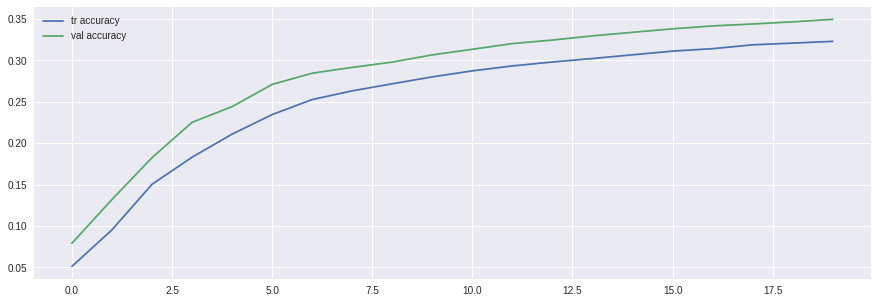

In [0]:
print(history)
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(history.history['acc'], label='tr accuracy')
ax.plot(history.history['val_acc'], label='val accuracy')
plt.legend()
plt.show()

In [0]:
model.evaluate(X_test, y_test, batch_size=32)

12231/12231 [==============================] - 9s 717us/step


[3.610875208392848, 0.3343144469118481]

## Qualitative Results

In [0]:
seeds = ['on tuesday there was a large fire and',
         'president of the bank was fired on the',
         'european oil executives could face charges of up']

In [0]:
def do_inference(seed, steps):
  
  prediction = []
  
  #print('seed: {}'.format(seed))
  while steps > 0:
    output = model.predict(seed)
    p = np.argmax(output)
    new_seed = np.append(seed[0, 1:], p).reshape(1,seq_len)
    #print('new_seed: {}'.format(new_seed))
    seed = new_seed
    prediction.append(p)
    steps -= 1
    
  return prediction
  

In [0]:
for s in seeds:
  
  vec = []
  
  for word in s.split():
      i = word_index[word]+3
      vec.append(i)
  
  vec = np.array(vec).reshape(1, seq_len,)
  print (vec)
  print(vec.shape)
  
  vec_pred = do_inference(vec, 10)
  
  print(s, end=' ')
  print(vec_to_text(vec_pred))

[[  19 1210  142   32    8  543 1770    7]]
(1, 8)
on tuesday there was a large fire and -- 000 tonnes of -- -- -- -- reuter 3
[[ 193    3    2   58   32 4205   19    2]]
(1, 8)
president of the bank was fired on the dollar the dollar dealers said the dollar dealers said the
[[ 292   63 2270  112 1340 1138    3   82]]
(1, 8)
european oil executives could face charges of up to -- mln dlrs in the year of the year


# Stateful Model

## Data
Organize training examples into batches

In [0]:
# Turn it into sequence/next pairs
seq_len=1
batch_size = 32
seq_len = 8
max_seq_len = 128
      
# Ensure each sequence is a maximum of 128 words
# If it's longer, chop it up into multiple training sequences

train_short = []
for x in train:
  if x.count(2)/len(x) <= 0.1: # use this headline only if there are fewer than 10% unknowns 
    i = 0
    while i < len(x):
      short_seq = x[i:i+max_seq_len] 
      if len(short_seq) < max_seq_len:
        short_seq = np.pad(short_seq, (0, max_seq_len - len(short_seq)), 'constant') # pad to max seq length
      train_short.append(short_seq) 
      i += max_seq_len

In [11]:
len(train_short)

5913

In [12]:
X_stateful  = []
y_stateful = []
  
batch_index = 0
while ((batch_index+1) * batch_size ) <= len(train_short):
  
  start = batch_index * batch_size
  end = start + batch_size
  train_batch = train_short[start:end] # okay now you have 32 whole headlines of length 128
  
  for i in range(max_seq_len - seq_len):
    for train_sample in train_batch:
      X_stateful.append(train_sample[i : i+seq_len])
      y_stateful.append(train_sample[i+seq_len])

  batch_index += 1

X_stateful = np.array(X_stateful)
y_stateful = np.array(y_stateful)
  
Xshape = X_stateful.shape
X_stateful = X_stateful.reshape(Xshape[0], Xshape[1], 1)
y_stateful = y_stateful.reshape(y_stateful.shape[0], 1)
print(X_stateful.shape)
print(y_stateful.shape)

(706560, 8, 1)
(706560, 1)


In [13]:
n_train = max_seq_len * 400
n_val = max_seq_len * 100

train_X_stateful = X_stateful[:n_train]
train_y_stateful = y_stateful[:n_train]
val_X_stateful = X_stateful[n_train:(n_train + n_val)]
val_y_stateful = y_stateful[n_train:(n_train + n_val)]
test_X_stateful = X_stateful[(n_train + n_val):(n_train + 2*n_val)]
test_y_stateful = y_stateful[(n_train + n_val):(n_train + 2*n_val)]

print(train_X_stateful.shape)

(51200, 8, 1)


In [0]:
# response variable should be one-hot
train_y_stateful = to_categorical(train_y_stateful, num_classes=vocab_size)
val_y_stateful = to_categorical(val_y_stateful, num_classes=vocab_size)
test_y_stateful = to_categorical(test_y_stateful, num_classes=vocab_size)

## Stateful Architecture

In [15]:
model = models.Sequential()

#         Embedding(vocab size, embedding size, input length (necessary for flatten and dense))
# model.add(Embedding(vocab_size, 64, input_length=seq_len))
model.add(LSTM(32, batch_input_shape=(batch_size, seq_len, 1), return_sequences=True)) # returns a sequence of vectors of dimension 32
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (32, 8, 32)               4352      
_________________________________________________________________
dropout_1 (Dropout)          (32, 8, 32)               0         
_________________________________________________________________
flatten_1 (Flatten)          (32, 256)                 0         
_________________________________________________________________
dense_1 (Dense)              (32, 2500)                642500    
Total params: 646,852
Trainable params: 646,852
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = []

history = model.fit(train_X_stateful, train_y_stateful,
          batch_size=batch_size, epochs=20, shuffle=False,
          validation_data=(val_X_stateful, val_y_stateful))

Instructions for updating:
Use tf.cast instead.
Train on 51200 samples, validate on 12800 samples
Epoch 1/20
51200/51200 [==============================] - 39s 760us/step - loss: 3.9885 - acc: 0.3946 - val_loss: 3.7288 - val_acc: 0.4209
Epoch 2/20
51200/51200 [==============================] - 36s 709us/step - loss: 3.5754 - acc: 0.4093 - val_loss: 3.7410 - val_acc: 0.4319
Epoch 3/20
51200/51200 [==============================] - 36s 693us/step - loss: 3.4354 - acc: 0.4154 - val_loss: 3.7887 - val_acc: 0.4348
Epoch 4/20
51200/51200 [==============================] - 36s 694us/step - loss: 3.3287 - acc: 0.4185 - val_loss: 3.8688 - val_acc: 0.4377
Epoch 5/20
51200/51200 [==============================] - 36s 702us/step - loss: 3.2735 - acc: 0.4199 - val_loss: 3.9486 - val_acc: 0.4384
Epoch 6/20
51200/51200 [==============================] - 36s 703us/step - loss: 3.1977 - acc: 0.4219 - val_loss: 4.0037 - val_acc: 0.4389
Epoch 7/20
51200/51200 [==============================] - 36s 699us/

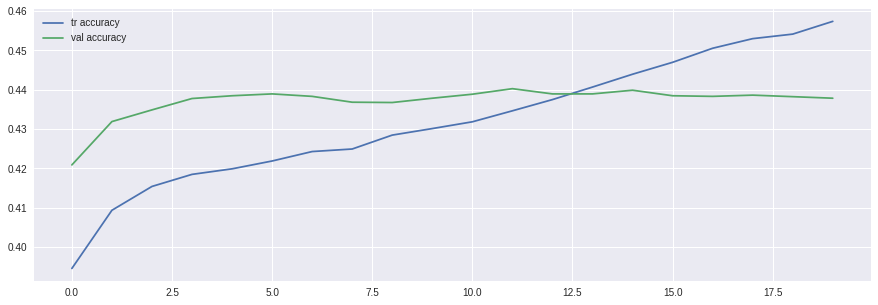

In [21]:
print(history)
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(history.history['acc'], label='tr accuracy')
ax.plot(history.history['val_acc'], label='val accuracy')
plt.legend()
plt.show()

In [0]:
def word_to_index(words):
  indices = []
  for word in words:
    if word == 'START':
      indices.append(1)
    elif word == '--':
      indices.append(2)
    elif word == 'END':
      indices.append(0) 
    else:
      indices.append(word_index[word]+3)
  return np.array(indices)

In [73]:
seeds =[['START', 'on', 'saturday', 'markets', 'reached', 'an', 'all', 'time'],
        ['START', 'when', 'the', 'fed', 'closed', 'on', 'friday', 'evening'],
        ['START', 'market', 'rally', 'reached', 'a', 'peak', 'number', 'after'],
        ['START', 'senior', 'executives', 'said', 'that', 'the', 'acquisition', 'will'],
        ['START', 'monday', 'afternoon', 'the', 'chairman', 'of', '--', 'co'],
        ['START', 'european', 'oil', 'companies', 'face', 'serious', 'regulatory', 'challenges'],
        ['START', 'prices', 'fell', 'below', '2', 'pct', 'after', 'earnings'], 
        ['START', 'executive', 'orders', 'went', 'out', 'but', 'the', 'chairman'],
        ['START', 'the', 'president', 'said', 'he', 'did', 'not', 'know'],
        ['START', 'chaos', 'resulted', 'from', 'the', 'deal', 'collapse', 'and'],
        ['START', 'banks', 'closed', 'after', 'record', 'high', 'however', 'the'],
        ['START', 'the', 'biggest', 'show', 'in', 'the', 'american', 'market'],
        ['START', 'a', 'new', 'chief', 'technological', 'officer', 'stepped', 'in'],
        ['START', 'black', 'friday', 'profits', 'were', 'lower', 'than', 'expected'],
        ['START', 'sales', 'rose', 'on', 'the', 'following', '--', 'when'],
        ['START', 'friday','evening', 'came', 'but', 'saturday', 'evening', 'was']]

ends = [['END'] * 8]*16
seeds = np.concatenate([seeds,  ends], axis=0)
seeds = np.apply_along_axis(word_to_index, 1, seeds)
seeds = seeds.reshape(32, 8, 1)
print(seeds[0])

[[   1]
 [  21]
 [2371]
 [ 236]
 [ 625]
 [  42]
 [ 137]
 [ 216]]


In [98]:
def do_stateful_inference(seed, steps):
  
  prediction = []
  
  #print('seed: {}'.format(seed))
  while steps > 0:
    output = model.predict(seed)
    p = np.argmax(output)
    new_seed = np.append(seed[0, 1:], p).reshape(1,seq_len)
    #print('new_seed: {}'.format(new_seed))
    seed = new_seed
    prediction.append(p)
    steps -= 1
    
  return prediction

# 
        
model.reset_states()

#prime the LSTM with the first input
output = model.predict(seeds, batch_size=batch_size)
#print(output)
pred_next = np.apply_along_axis(np.argmax, 1, output)
#print(seeds)

preds = pred_next.T.reshape(batch_size, 1)
prev_input = seeds

#while (list(pred_next_batch).count(0) < 32):
for i in range(10):  
  next_input = np.concatenate([prev_input, np.array(pred_next).reshape(batch_size, 1, 1)], axis=1)
  next_input = next_input[:, 1:, :]
  #print(next_input)
  
  output = model.predict(next_input, batch_size=batch_size)
  #print(output)
  pred_next = np.apply_along_axis(np.argmax, 1, output)
  
  preds = np.concatenate([preds, pred_next.T.reshape(batch_size, 1)], axis=1)
  
  prev_input = next_input
  
  print(list(pred_next).count(0))
  

    
# for s in seeds:
#   vec = []
#   for word in s.split():
#       i = word_index[word]+1
#       vec.append(i)
  
  
#   vec = np.array(vec).reshape(1, seq_len,)
#   print (vec)
#   print(vec.shape)
  
#   vec_pred = do_inference(vec, 10)
  
#   print(s, end=' ')
#   print(vec_to_text(vec_pred))

16
17
17
17
17
17
17
17
17
17


In [101]:
print(preds[:16])
for i in range(16):
  print(vec_to_text(seeds[i]))
  print(vec_to_text(preds[i]))

[[   2    2 1683    2    2    2    6    4    2    2    2]
 [2288    2    2    8    2    2    5    4  258    9    4]
 [   2    2    2    2    2    2    2    4    4  253    8]
 [   2    6  601    5    2    2    2  113    2    8    4]
 [ 357    4    2    2    2    2    2    4    4  253    8]
 [   2    2    8    2    2    5    4  258    9    4    2]
 [  26   12    0    0    0    0    0    0    0    0    0]
 [   2    2    2    2    2    2  159   36    8    2    2]
 [   6    4    2    2    2    2    2    2    2    2    2]
 [   4    2  511    4    4    2    2    2    2    2    4]
 [   2    2    2    2    2    4    4  253    8    4    2]
 [   4    2    2    2    2    2    9    4  253    8    4]
 [   4    2    2    2    4    2    2 1414    8    4  493]
 [   2    2    2    2    2    8    4    2  253    8    4]
 [   2    2  195    6    4  460  490  973    2    2    8]
 [  14    2   18   14    2   18   86  180   53   11   14]]
START on saturday markets reached an all time
-- -- deputy -- -- -- to 